In [1]:
import os               # подключаем требуемые пакеты
import numpy as np
import sympy as sp
import pandas as pd
from itertools import islice
import math
import time
import scipy.stats
from scipy import optimize
import matplotlib as mpl
import matplotlib.pyplot as plt 
import pylab
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import openpyxl as px

In [3]:
wb = px.load_workbook('RIH9.xlsx', data_only = True)  # подружаем файл с исходными данными

In [4]:
sheet = wb['Лист1']

In [5]:
data = sheet.values                 # записываем данные из файла в dataFrame

cols = next(data)[0:]

data = list(data)[0:]

idx = [r for r in range(0,len(data))]

df = pd.DataFrame(data,index = idx, columns=cols) 

In [6]:
df

,Страйк,Цена_BID,Цена_ASK,Тип,Время до экспирации (в годах)
0,112500,10,20,PUT,0.003968
1,115000,30,40,PUT,0.003968
2,117500,110,130,PUT,0.003968
3,120000,670,700,CALL,0.003968
4,122500,70,80,CALL,0.003968
5,110000,60,80,PUT,0.023810
6,112500,100,120,PUT,0.023810
7,115000,250,300,PUT,0.023810
8,117500,650,710,PUT,0.023810
9,120000,1470,1640,CALL,0.023810


In [7]:
# 1-ый этап

# Задаем S - текущая цена базового актива и r - безрисковая процентная ставка
S = 120035
r = 0.01

#Решаем уравнения относительно волатильности
d1 = np.zeros(len(data))
d2 = np.zeros(len(data))
BIDsigma = np.zeros(len(data))
ASKsigma = np.zeros(len(data))
resB = np.zeros(len(data))

#Описываем это уравнение
def f(x, S, K, r, T, B, Param):
    d1 = (np.log(S / K) + (r + (x**2) / 2) * T) / (x  * np.sqrt(T))
    d2 = d1 - x * np.sqrt(T)
    if B == 'CALL':
        res = (S * scipy.stats.norm.cdf(d1) - K * np.exp(-r * T) * scipy.stats.norm.cdf(d2) - Param)
    else:
        res = (-S * scipy.stats.norm.cdf(-d1) + K * np.exp(-r * T) * scipy.stats.norm.cdf(-d2) - Param)
    return res

for i in range(0, len(data)):
    K = df.loc[i,'Страйк']
    T = df.loc[i,'Время до экспирации (в годах)']
    B = df.loc[i,'Тип']
    BID = df.loc[i,'Цена_BID']
    ASK = df.loc[i,'Цена_ASK']
    #z = np.arange(0,0.5,0.00001)
    #plt.grid(True)
    #plt.plot(z,f(z,S, K, r, T, B, ASK))
    #plt.show()
    x0BID = [0.42,0.36,0.16,0.2,0.22,0.3,0.25,0.16,0.12,0.19,        #устанавливаем начальное приближение корня
             0.2,0.2,0.2,0.31,0.28,0.26,0.25,0.23,0.22,0.2,
             0.19,0.19,0.19,0.3,0.27,0.27,0.26,0.25,0.24,0.23,
             0.21,0.21,0.2,0.2,0.19,0.2,0.2,0.2]
    x0ASK = [0.46, 0.37, 0.22,0.2, 0.22, 0.23, 0.32, 0.26, 0.25, 0.23, 
             0.21, 0.2, 0.2, 0.21, 0.32, 0.28, 0.26, 0.25, 0.23, 
             0.21, 0.2, 0.2, 0.19, 0.2, 0.2, 0.31, 0.29, 0.28, 
             0.27, 0.26, 0.25, 0.24, 0.22, 0.21, 0.21, 0.2, 0.2, 0.2]
    # Получаем массив волатильности BID
    BIDsigma[i] = optimize.newton(f, x0BID[i], args = (S, K, r, T, B, BID,), tol=1e-5, maxiter = 100)
    # Получаем массив волатильности ASK
    ASKsigma[i] = optimize.newton(f, x0ASK[i], args = (S, K, r, T, B, ASK,), tol=1e-5, maxiter = 100)
    #print(f(BIDdeltas[i],S, K, r, T, B, BID)) #<---проверка 
    #print(f(ASKdeltas[i],S, K, r, T, B, ASK))
print('BID sigma: ',BIDsigma)                          #<--вывод массивов волатильности
print('ASK sigma: ',ASKsigma)

BID sigma:  [0.43747417 0.35975074 0.27678833 0.21548705 0.23481585 0.2998701
 0.25849901 0.23646393 0.22147806 0.19466802 0.19661127 0.19359358
 0.1931964  0.30918303 0.28040528 0.26361466 0.247736   0.23088702
 0.21597925 0.19768578 0.19136887 0.1895214  0.18799193 0.19227122
 0.29919888 0.28719492 0.27631812 0.26591808 0.25680875 0.24579899
 0.23621983 0.21802403 0.21170791 0.20593455 0.20032595 0.19699111
 0.19352888 0.19063914]
ASK sigma:  [0.47989011 0.37832578 0.29050661 0.22543674 0.24295941 0.31536205
 0.26856123 0.24984038 0.23141375 0.217687   0.20323752 0.19999239
 0.21706091 0.31677245 0.29185822 0.27172428 0.25214777 0.23534496
 0.21961214 0.20183346 0.19493247 0.19067093 0.19321867 0.19523356
 0.31266911 0.292648   0.27851213 0.27302741 0.25981004 0.24841924
 0.24038644 0.22258056 0.2163499  0.21102197 0.20636223 0.20468985
 0.20024566 0.1986716 ]


In [12]:
# 2-ой этап

# коэффициент бета
b = 1

# вспомогательные функции для SABRsigma
def a(T, p):
    return p[0] + (p[1] + p[2] * T/ p[3]) * np.exp(-T / p[3])

def v(T, p):
    return p[4] + (p[5] + p[6] * T / p[7]) * np.exp(-T / p[7])

def p_(T, p):
    return p[8] + (p[9] + p[10] * T / p[11]) * np.exp(-T / p[11])

def f(T):
    return S * np.exp(r * T)

def z(T, K, p):
    return (v(T, p) / a(T, p)) * ((f(T) * K) ** ((1 - b)/2)) * np.log(f(T) / K)

def xi(T, K, p):
    return np.log(np.fabs((np.sqrt(np.fabs(1 - 2 * p_(T, p) * z(T, K, p) + z(T, K, p) ** 2)) + z(T, K, p) - p_(T, p)) / (1 - p_(T, p))))

# Формула SABR для поверхности волатильности
#def SABRsigma(p, T, K):                 
 #   return (a(T, p) * (1 + (((1 - b) ** 2) * (a(T, p) ** 2) / (24 * ((f(T) * K) ** (1 - b))) + 0.25 * p_(T, p) * b * v(T, p) * a(T, p) / ((f(T) * K) ** ((1 - b)/2)) + (2-3*(p_(T,p)**2)) * (v(T,p)**2) / 24) ) * T) /((f(T) * K) ** ((1 - b)/2) * (1 + (1 - b) ** 2 / 24 * np.log(np.fabs(f(T) / K)) ** 2 + (1 - b) ** 4 / 1920 * np.log(np.fabs(f(T) / K)) ** 4)) * z(T, K, p) / xi(T, K, p)
    
def SABRsigma1(p, T, K):
    return (a(T, p) * (1 + (((1 - b) ** 2) * (a(T, p) ** 2) / (24 * ((f(T) * K) ** (1 - b))) + 0.25 * p_(T, p) * b * v(T, p) * a(T, p) / ((f(T) * K) ** ((1 - b)/2)) + (2-3*(p_(T,p)**2)) * (v(T,p)**2) / 24) ) * T)
def SABRsigma2(p, T, K):
    return ((f(T) * K) ** ((1 - b)/2) * (1 + (1 - b) ** 2 / 24 * (np.log(np.fabs(f(T) / K)) ** 2) + ((1 - b) ** 4 / 1920) * np.log(np.fabs(f(T) / K)) ** 4))
def SABRsigma(p, T, K):
    return SABRsigma1(p,T,K) / SABRsigma2(p, T, K) * z(T, K, p) / xi(T, K, p)
# Формула cуммы разностей квадратов
def SS(p, T, K, Param):
    delta = (SABRsigma(p, T, K) - Param) 
    return delta

T = np.zeros(len(data))
K = np.zeros(len(data))

for i in range(0, len(data)):
        T[i] = df.loc[i,'Время до экспирации (в годах)']
        K[i] = df.loc[i,'Страйк']

def SABR(p, T, K, Param):
    res = 0.0
    sigma1 = SABRsigma(p, T, K)
    sigma2 = Param
    for i in range(0,len(T)):
        res = res + (sigma1 - sigma2) ** 2
    return res


guessBID = [4.2,  3.1,  2.2, 1, 3.1, 4.5, 0.8, 0.5, 4.6, 3.1,  0.2, 0.1]


lbBID =    [0, -9, -3,   0, -7,   0,   0,  -2,  -8, 0, -4,  -3]
rbBID =    [11, 15,  6,   7,  4,   16,   3,   1,  10, 6,  12,   16]


guessASK = [4.2,  3.1,  2.2, 1, 3.1, 4.5, 0.8, 0.5, 4.6, 3.1,  0.2, 0.1]

lbASK =    [0, -9, -3,   0, -7,   0,   0,  -2,  -8, 0, -4,  -3]
rbASK =    [11, 15,  6,   7,  4,   16,   3,   1,  10, 6,  12,   16]

# методом наименьших квадратов ищем p


pBID = optimize.least_squares(SS, x0 = guessBID, bounds = (lbBID,rbBID), args=(T, K, BIDsigma))
print('Estimates pBID from leastsq \n', pBID.x)
print('\n')
pASK = optimize.least_squares(SS, x0 = guessASK, bounds = (lbASK,rbASK), args=(T, K, ASKsigma))
print('Estimates pASK from leastsq \n', pASK.x)

SABRsigmaBID = SABRsigma(pBID.x, T, K)
SABRsigmaASK = SABRsigma(pASK.x, T, K)

print(ASKsigma)
print(SABRsigmaASK)

print('Абсолютная погрешность sigma по BID: ', np.mean(np.fabs(BIDsigma - SABRsigmaBID)))
print('Абсолютная погрешность sigma по ASK: ', np.mean(np.fabs(ASKsigma - SABRsigmaASK)))

/home/ilya/miniconda3/envs/cryptocurrency-analysis/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in square
/home/ilya/miniconda3/envs/cryptocurrency-analysis/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/home/ilya/miniconda3/envs/cryptocurrency-analysis/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Estimates pBID from leastsq 
 [ 1.69874428e+00  2.83385196e+01 -3.61392814e-02  1.36130303e-02
  8.38660927e-02  4.18683849e+00  7.07170365e-01  6.21442289e-05
  4.52874980e+00  2.94633453e+00  1.89574483e-01  3.67648692e-05]


Estimates pASK from leastsq 
 [ 7.54506269e-01  6.67784870e+00 -2.99997931e+00  7.25701679e-02
  4.00000000e+00  1.60000000e+01  2.99118285e+00  1.24092283e-02
 -3.03228234e-01  2.67704261e+00  8.23183030e-02  7.88615217e-05]
[0.47989011 0.37832578 0.29050661 0.22543674 0.24295941 0.31536205
 0.26856123 0.24984038 0.23141375 0.217687   0.20323752 0.19999239
 0.21706091 0.31677245 0.29185822 0.27172428 0.25214777 0.23534496
 0.21961214 0.20183346 0.19493247 0.19067093 0.19321867 0.19523356
 0.31266911 0.292648   0.27851213 0.27302741 0.25981004 0.24841924
 0.24038644 0.22258056 0.2163499  0.21102197 0.20636223 0.20468985
 0.20024566 0.1986716 ]
[0.32595846 0.32291065 0.32013582 0.3176326  0.31539851 0.24434313
 0.24289613 0.24154581 0.2402895  0.23912455 0.238048

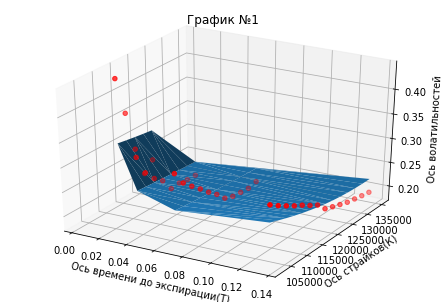

In [9]:
# 3-ий этап

# Строим график зависимости (T, K, sigmaBID)

x = T
y = K
z = BIDsigma

fig = pylab.figure()
axes = Axes3D(fig)
axes.scatter(x, y, z, color = 'r')
#axes.plot_trisurf(x, y, z, color = 'r')

axes.set_ylabel(u'Ось страйков(К)')
axes.set_xlabel(u'Ось времени до экспирации(T)')
axes.set_zlabel(u'Ось волатильностей')
axes.set_title(u'График №1')

# Cтроим поверхность волатильности

axes.plot_trisurf(x,y, SABRsigmaBID)
#axes.scatter(x,y, SABRsigmaBID)
pylab.show()


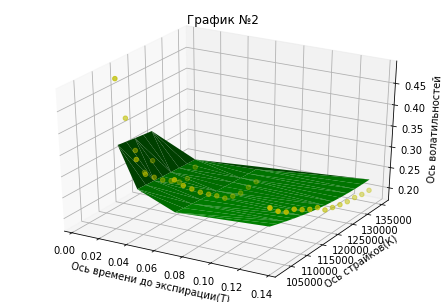

In [10]:
# Строим график зависимости (T, K, sigmaASK)

x = T
y = K
z = ASKsigma

fig = pylab.figure()
axes = Axes3D(fig)
axes.scatter(x, y, z, color = 'y')
axes.set_ylabel(u'Ось страйков(К)')
axes.set_xlabel(u'Ось времени до экспирации(T)')
axes.set_zlabel(u'Ось волатильностей')
axes.set_title(u'График №2')

# Cтроим поверхность волатильности

axes.plot_trisurf(x, y, SABRsigmaASK, color = 'g')
#axes.scatter(x, y, SABRsigmaASK, color = 'g')
pylab.show()


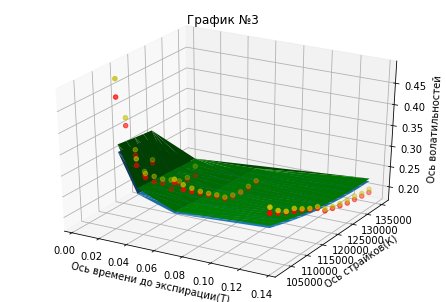

In [11]:
# Cтроим итоговый график

x = T 
y = K
z1 = BIDsigma
z2 = ASKsigma

fig = pylab.figure()
axes = Axes3D(fig)

axes.set_ylabel(u'Ось страйков(К)')
axes.set_xlabel(u'Ось времени до экспирации(T)')
axes.set_zlabel(u'Ось волатильностей')
axes.set_title(u'График №3')

# Cтроим поверхность волатильности

axes.plot_trisurf(x,y, SABRsigmaBID)
axes.plot_trisurf(x,y, SABRsigmaASK, color = 'g')

axes.scatter(x, y, z1, color = 'r')
axes.scatter(x, y, z2, color = 'y')

pylab.show()